In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# Classifier Models

In [2]:
df = pd.read_csv('CANCER_TABLE.csv').rename(columns={'diameter (cm)': 'diameter', ' cancer': 'cancer'})
df['prediction'] = df.diameter > 7
df

,diameter,cancer,prediction
0,6.309685,False,False
1,4.580894,False,False
2,6.310071,False,False
3,7.495139,False,True
4,2.216181,False,False
...,...,...,...
995,7.831124,False,True
996,4.614356,False,False
997,6.988584,False,False
998,1.367865,False,False


In [3]:
def get_confusion_matrix(df):
    confusion_matrix = df.groupby(['cancer', 'prediction']).size().unstack(0).fillna(0)\
        .sort_index(ascending=False).sort_index(axis=1, ascending=False)
    return confusion_matrix

confusion_matrix = get_confusion_matrix(df)

In [4]:
TP = confusion_matrix.loc[True, True]
TN = confusion_matrix.loc[False, False]
FP = confusion_matrix.loc[True, False]
FN = confusion_matrix.loc[False, True]

print('TP = ', TP)
print('TN = ', TN)
print('FP = ', FP)
print('FN = ', FN)

accuracy = (TP + TN) / (confusion_matrix.sum().sum())
precision = (TP / (TP + FP))
recall = (TP / (TP + FN))
f1 = 2 * precision * recall / (precision + recall)

print(f'accuracy is {accuracy:.2%}')
print(f'precision is {precision:.2%}')
print(f'recall is {recall:.2%}')
print(f'f1 score is {f1:.2%}')

TP =  193.0
TN =  689.0
FP =  118.0
FN =  0.0
accuracy is 88.20%
precision is 62.06%
recall is 100.00%
f1 score is 76.59%


TP cancer patients 

In [5]:
accuracy = (TP + TN) / (confusion_matrix.sum().sum())
precision = (TP / (TP + FP))
recall = (TP / (TP + FN))
f1 = 2 * precision * recall / (precision + recall)

print(f'accuracy is {accuracy:.2%}')
print(f'precision is {precision:.2%}')
print(f'recall is {recall:.2%}')
print(f'f1 score is {f1:.2%}')

accuracy is 88.20%
precision is 62.06%
recall is 100.00%
f1 score is 76.59%


# Ranking Model

The value in a ranking model over a classifier is that it allows one to shift the decision value so that a wanted value of recall/precision is achieved.

In [6]:
def get_fpr(confusion_matrix):
    if False not in confusion_matrix.index:
        return 1
    TN = confusion_matrix.loc[False, False]
    FP = confusion_matrix.loc[True, False]
    return FP / (FP + TN)

def get_tpr(confusion_matrix):
    if False not in confusion_matrix.index:
        return 1
    TP = confusion_matrix.loc[True, True]
    FN = confusion_matrix.loc[False, True]
    return TP / (TP + FN)

In [7]:
fpr_list = [0]
tpr_list = [0]

df.prediction = False
for d in sorted(df.diameter, reverse=True):
    df.loc[df.diameter >= d, 'prediction'] = True
    confusion_matrix = get_confusion_matrix(df)
    fpr_list.append(get_fpr(confusion_matrix))
    tpr_list.append(get_tpr(confusion_matrix))

In [8]:
df = df.sort_values('diameter', ascending=False, ignore_index=True)

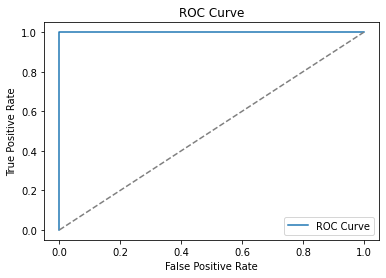

In [9]:
plt.plot(fpr_list, tpr_list, label='ROC Curve')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [10]:
def compute_auc(fpr_list, tpr_list):
    auc = 0 
    for i in range(len(fpr_list) - 1):
        auc += (tpr_list[i + 1] + tpr_list[i]) * (fpr_list[i + 1] - fpr_list[i]) / 2
    return auc

compute_auc(fpr_list, tpr_list)

1.0

In terms of AUC, this is a very good model, i.e. it has a 100% of currectly classifying a random positive sample.

In order to turn the model to a classification model, I'll choose the maximal diameter value that achieves 100% TPR as the threshold, that way we reach the maximal FPR.

In [11]:
df.prediction = False
for d in sorted(df.diameter, reverse=True):
    df.loc[df.diameter >= d, 'prediction'] = True
    confusion_matrix = get_confusion_matrix(df)
    tpr = get_tpr(confusion_matrix)
    if tpr == 1:
        break
threshold = d
print(d)
df.loc[df.diameter >= threshold, 'prediction'] = True

8.02744867175


In [12]:
confusion_matrix = get_confusion_matrix(df)
confusion_matrix

cancer,True,False
prediction,,
True,193.0,0.0
False,0.0,807.0


In [13]:
TP = confusion_matrix.loc[True, True]
TN = confusion_matrix.loc[False, False]
FP = confusion_matrix.loc[True, False]
FN = confusion_matrix.loc[False, True]

print('TP = ', TP)
print('TN = ', TN)
print('FP = ', FP)
print('FN = ', FN)

accuracy = (TP + TN) / (confusion_matrix.sum().sum())
precision = (TP / (TP + FP))
recall = (TP / (TP + FN))
f1 = 2 * precision * recall / (precision + recall)

print(f'accuracy is {accuracy:.2%}')
print(f'precision is {precision:.2%}')
print(f'recall is {recall:.2%}')
print(f'f1 score is {f1:.2%}')

TP =  193.0
TN =  807.0
FP =  0.0
FN =  0.0
accuracy is 100.00%
precision is 100.00%
recall is 100.00%
f1 score is 100.00%


This model is vastly superior to the previous one, as it reaches 100% on all metrics.

In [17]:
fprs, tprs, _ = metrics.roc_curve(df.cancer, df.diameter)


(array([0., 0., 0., 1.]),
 array([0.        , 0.00518135, 1.        , 1.        ]),
 array([10.99468786,  9.99468786,  8.02744867,  0.0592936 ]))